# ISLP - Chapter 10 - Exercise 12
### Author: pzuehlke

Again, the solution will be almost identical to those of the previous
exercises. We need to one-hot encode the `day_of_week` variable and expand the
input dimension of the RNN to accommodate the additional features.

We begin by importing the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from torchinfo import summary
from ISLP import load_data

Checking for a GPU:

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


Loading the NYSE data:

In [3]:
nyse = load_data("NYSE")
print(nyse.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6051 entries, 1962-12-03 to 1986-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   day_of_week     6051 non-null   category
 1   DJ_return       6051 non-null   float64 
 2   log_volume      6051 non-null   float64 
 3   log_volatility  6051 non-null   float64 
 4   train           6051 non-null   bool    
dtypes: bool(1), category(1), float64(3)
memory usage: 201.1+ KB
None


In [4]:
nyse.head()

,day_of_week,DJ_return,log_volume,log_volatility,train
date,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1962-12-04,tues,0.007813,0.346202,-11.749305,True
1962-12-05,wed,0.003845,0.525306,-11.665609,True
1962-12-06,thur,-0.003462,0.210182,-11.626772,True
1962-12-07,fri,0.000568,0.044187,-11.728130,True


In [5]:
cols = ["DJ_return", "log_volume", "log_volatility"]
data = nyse[cols].copy()

day_dummies = pd.get_dummies(nyse["day_of_week"], drop_first=True).astype(int)
data = pd.concat([data, day_dummies], axis=1)
day_cols = day_dummies.columns.tolist()
all_cols = cols + day_cols
print(all_cols)

['DJ_return', 'log_volume', 'log_volatility', 'tues', 'wed', 'thur', 'fri']


In [6]:
# Create lagged features, including the `day_of_week` one-hot encoded columns:
L = 5
for i in range(1, L + 1):
    for col in all_cols:
        data[f"{col}_{i}"] = data[col].shift(i)
data.dropna(inplace=True)
data.head()

,DJ_return,log_volume,log_volatility,tues,wed,thur,fri,DJ_return_1,log_volume_1,log_volatility_1,...,wed_4,thur_4,fri_4,DJ_return_5,log_volume_5,log_volatility_5,tues_5,wed_5,thur_5,fri_5
date,,,,,,,,,,,,,,,,,,,,,
1962-12-10,-0.010824,0.133246,-10.872526,0,0,0,0,0.000568,0.044187,-11.728130,...,0.0,0.0,0.0,-0.004461,0.032573,-13.127403,0.0,0.0,0.0,0.0
1962-12-11,0.000124,-0.011528,-10.977797,1,0,0,0,-0.010824,0.133246,-10.872526,...,1.0,0.0,0.0,0.007813,0.346202,-11.749305,1.0,0.0,0.0,0.0
1962-12-12,0.003358,0.001607,-11.012360,0,1,0,0,0.000124,-0.011528,-10.977797,...,0.0,1.0,0.0,0.003845,0.525306,-11.665609,0.0,1.0,0.0,0.0
1962-12-13,-0.003296,-0.106437,-11.047108,0,0,1,0,0.003358,0.001607,-11.012360,...,0.0,0.0,1.0,-0.003462,0.210182,-11.626772,0.0,0.0,1.0,0.0
1962-12-14,0.004469,-0.138269,-11.022063,0,0,0,1,-0.003296,-0.106437,-11.047108,...,0.0,0.0,0.0,0.000568,0.044187,-11.728130,0.0,0.0,0.0,1.0


Next we split the data chronologically and extract the target (log-volume):

In [7]:
data.index = pd.to_datetime(data.index)
cutoff_date = pd.to_datetime("1980-01-02")
train_data = data[data.index < cutoff_date]
test_data = data[data.index >= cutoff_date]

y_train = train_data["log_volume"]
y_test = test_data["log_volume"]

lag_cols = [f"{col}_{i}" for i in range(1, L + 1) for col in all_cols]

X_train = train_data[lag_cols]
X_test  = test_data[lag_cols]

Next, we prepare the data in RNN format and convert it to tensors:

In [8]:
# Reorganize and reshape for RNN format (time steps, features):
ordered_cols = [f"{col}_{i}" for i in range(L, 0, -1) for col in all_cols]
print(ordered_cols)

['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'tues_5', 'wed_5', 'thur_5', 'fri_5', 'DJ_return_4', 'log_volume_4', 'log_volatility_4', 'tues_4', 'wed_4', 'thur_4', 'fri_4', 'DJ_return_3', 'log_volume_3', 'log_volatility_3', 'tues_3', 'wed_3', 'thur_3', 'fri_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2', 'tues_2', 'wed_2', 'thur_2', 'fri_2', 'DJ_return_1', 'log_volume_1', 'log_volatility_1', 'tues_1', 'wed_1', 'thur_1', 'fri_1']


The following code cell is identical to the corresponding one in Exercise $ 11 $:

In [9]:
# Reindex to get proper column order:
X_ordered_train = X_train.reindex(columns=ordered_cols).values
X_ordered_test  = X_test.reindex(columns=ordered_cols).values

# Reshape to (samples, time_steps, features):
X_rnn_train = X_ordered_train.reshape(-1, L, len(all_cols))
X_rnn_test  = X_ordered_test.reshape(-1, L, len(all_cols))
print(X_rnn_train.shape)

# Convert to tensors:
X_train_tensor = torch.Tensor(X_rnn_train).to(device)
X_test_tensor  = torch.Tensor(X_rnn_test).to(device)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_test_tensor  = torch.Tensor(y_test.values).to(device)

# Create DataLoader:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

(4276, 5, 7)


Now we'll implement the RNN. We need to modify the code from Exercise $ 11 $
slightly, but the template is the same as that on p. $ 462 $ of the book:

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=12, dropout_rate=0.1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(hidden_size, 1)
        

    def forward(self, x):
        # x shape: (batch, time_steps, features)
        val, h_n = self.rnn(x)  # val shape: (batch, time_steps, hidden_size)
        # val[:, -1] shape: (batch, hidden_size)
        val = self.dropout(val[:, -1])  # shape: (batch, hidden_size)
        val = self.dense(val)   # shape: (batch, 1)
        return val.squeeze(-1)

Let's instantiate the model and check its structure:

In [11]:
input_size = len(all_cols)
model = RNN(input_size=input_size).to(device)
summary(model, input_size=(64, L, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [64]                      --
├─RNN: 1-1                               [64, 5, 12]               252
├─Dropout: 1-2                           [64, 12]                  --
├─Linear: 1-3                            [64, 1]                   13
Total params: 265
Trainable params: 265
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.08
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.04

From here on the code is identical to that in the previous exercise. First
we set the loss function and optimizer:

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Now we train the model using $ 1\,000 $ epochs (this cell takes about a minute to run!):

In [13]:
num_epochs = 1_000
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward and optimize:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    losses.append(average_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}]  "
              f"Loss: {average_loss:.4f}")

Epoch [100/1000]  Loss: 0.0224
Epoch [200/1000]  Loss: 0.0214
Epoch [300/1000]  Loss: 0.0214
Epoch [400/1000]  Loss: 0.0215
Epoch [500/1000]  Loss: 0.0213
Epoch [600/1000]  Loss: 0.0211
Epoch [700/1000]  Loss: 0.0211
Epoch [800/1000]  Loss: 0.0211
Epoch [900/1000]  Loss: 0.0208
Epoch [1000/1000]  Loss: 0.0209


Now we evaluate the model by computing its $ R^2 $ on the test set.
Then we plot actual and predicted log volumes in a time series covering
the test period.

RNN model including day of the week - test R^2: 0.4588


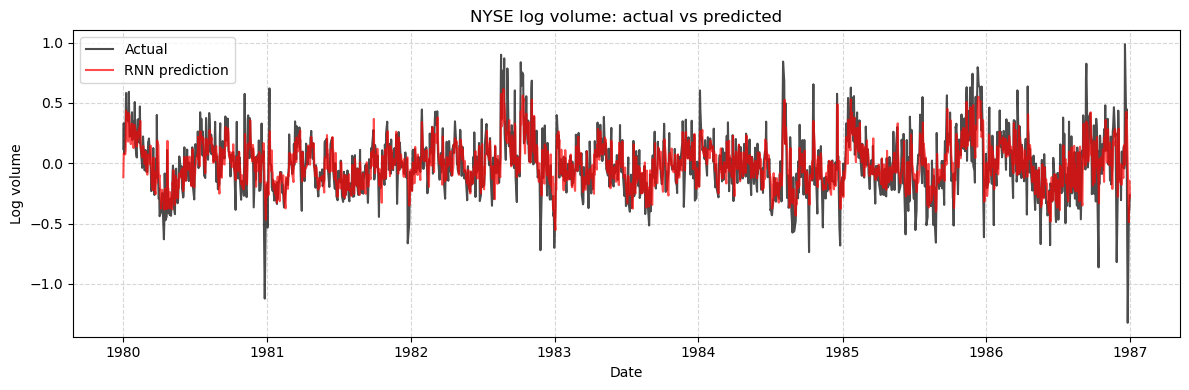

In [18]:
# Evaluate the model:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

r2 = r2_score(y_test, y_test_pred)
print(f"RNN model including day of the week - test R^2: {r2:.4f}")

# Compare predictions:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_data.index, y_test, label="Actual", color="black", alpha=0.7)
ax.plot(test_data.index, y_test_pred,
        label="RNN prediction", color="red", alpha=0.7)
ax.set_title("NYSE log volume: actual vs predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Log volume")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()
plt.show()

I obtained a test $ R^2 $ of $ 45.9\% $. This is a considerable improvement over
both the linear AR model, nonlinear AR model, and RNN model that do not use the
day of the week (p. $ 464 $). However, it is not better than the test $ R^2 $ of
$ 46.0\% $ and $ 46.6\% $ achieved by the linear and nonlinear AR models that do
include the information about the day of the week (see pp. $ 461 $ and $ 465 $).
This is a somewhat disappointing result since the linear AR model is much easier
to fit and interpret. On the other hand, this situation is in line with some of
the authors' warnings at several points in the book that the most flexible or
fancier models do not always yield the best results.